## setup

In [191]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
import pandas as pd

# MAX_RETRIES = 3


load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise ValueError("Missing GROQ_API_KEY in .env")

# Init LLM
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=GROQ_API_KEY)


## Set state

In [192]:
class TestGenState(TypedDict):
    requirement: str
    sanity: List[str]
    regression: List[str]
    detailed: List[str]
    all_tests: List[dict]
    attempt: int

## Define the nodes

In [193]:
def init_state(state: TestGenState) -> TestGenState:
    return {
        "sanity": [],
        "regression": [],
        "detailed": [],
        "all_tests": [],
        "attempt": 0
    }
def parse_requirement(state: TestGenState) -> TestGenState:
    """
    Node: Parse Requirement
    Purpose: Prepare the requirement text for the LLM.
    Input: state['requirement'] (string)
    Output: state['requirement'] (string)
    """
    
    return {"requirement": state["requirement"]}




def generate_sanity_tests(state: TestGenState) -> TestGenState:
    """Node: Generate sanity-level test steps (acceptance test).
    Purpose: Use LLM to generate structured sanity-level test steps (acceptance test)test cases for a requirement.
    Input: state['requirement'] (string)
    Output: state['sanity'] (list of test cases with fields: id, description, steps, expected, type)
    """
    
    prompt = f"""Generate 3 sanity test cases for the requirement:
    {state['requirement']}
    Only include basic verification steps.
    Each test case must include the following fields:
    - id
    - description
    - steps
    - expected
    - type (sanity)
    """
    resp = llm.invoke(prompt)
    steps = [s.strip() for s in resp.content.split("\n") if s.strip()]
    state["sanity"] = steps
    return state

def generate_regression_tests(state: TestGenState) -> TestGenState:
    """Node: Generate regression-level test steps (deep E2E).
    Purpose: Use LLM to generate structured regression-level test steps (deep E2E) test cases for a requirement.
    Input: state['requirement'] (string)
    Output: state['regression'] (list of test cases with fields: id, description, steps, expected, type)
    """

    prompt = f"""Generate 3 regression test cases for the requirement:
    {state['requirement']}
    Cover full end-to-end flows.
    Only include basic verification steps.
    Each test case must include the following fields:
    - id
    - description
    - steps
    - expected
    - type (regression)
    """
    resp = llm.invoke(prompt)
    steps = [s.strip() for s in resp.content.split("\n") if s.strip()]
    state["regression"] = steps
    return state


def generate_detailed_tests(state: TestGenState) -> TestGenState:
    """Node: Generate detailed test steps (edge cases / complex flows).
    Purpose: Use LLM to generate structured detailed test steps (edge cases and complex tests) test cases for a requirement.
    Input: state['requirement'] (string)
    Output: state['detailed'] (list of test cases with fields: id, description, steps, expected, type)
    """
    prompt = f"""
    Generate 3 detailed test steps for the requirement:
    {state['requirement']}
    Include edge cases, complex flows, and boundary conditions.
    Only include basic verification steps.
    Each test case must include the following fields:
    - id
    - description
    - steps
    - expected
    - type (detailed)
    """
    resp = llm.invoke(prompt)
    steps = [s.strip() for s in resp.content.split("\n") if s.strip()]
    state["detailed"] = steps
    return state

def merge_tests(state: TestGenState) -> TestGenState:
    """Node: Merge all test types into a single list of dicts."""
    all_tests = []
    for t_type in ["sanity", "regression", "detailed"]:
        for step in state.get(t_type, []):
            all_tests.append({"type": t_type, "step": step})
    state["all_tests"] = all_tests
    return state

def export_tests(state: TestGenState, file_path="test_cases.csv") -> TestGenState:
    """Node: Export all tests to CSV and display DataFrame."""
    df = pd.DataFrame(state.get("all_tests", []))
    df.to_csv(file_path, index=False)
    display(df)
    state["exported_file"] = file_path
    return state

'''
def is_retry_needed(state: TestGenState) -> str:
    """Return continue if JSON invalid and attempts < MAX_RETRIES."""
    valid = True
    
    state["valid"] = valid
    if not valid and state["attempt"] < MAX_RETRIES:
        return  "continue"
    return "end"
'''

'\ndef is_retry_needed(state: TestGenState) -> str:\n    """Return continue if JSON invalid and attempts < MAX_RETRIES."""\n    valid = True\n\n    state["valid"] = valid\n    if not valid and state["attempt"] < MAX_RETRIES:\n        return  "continue"\n    return "end"\n'

## setup the graph

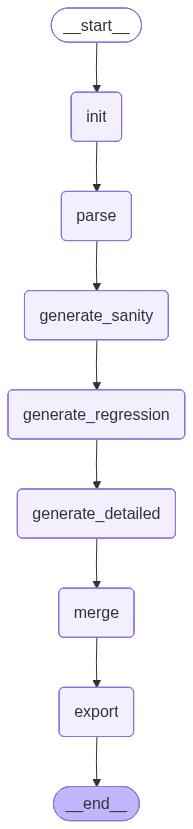

In [194]:
workflow = StateGraph(TestGenState)
workflow.add_node("init", init_state)
workflow.add_node("parse", parse_requirement)
workflow.add_node("generate_sanity", generate_sanity_tests)
workflow.add_node("generate_regression", generate_regression_tests)
workflow.add_node("generate_detailed", generate_detailed_tests)
workflow.add_node("merge", merge_tests)
workflow.add_node("export", export_tests)

workflow.set_entry_point("init")

# Normal flow
workflow.add_edge("init", "parse")
workflow.add_edge("parse", "generate_sanity")
workflow.add_edge("generate_sanity", "generate_regression")
workflow.add_edge("generate_regression", "generate_detailed")
workflow.add_edge("generate_detailed", "merge")
workflow.add_edge("merge", "export")
workflow.add_edge("export", END)

# Retry flow
'''
workflow.add_conditional_edges('generate_sanity', #Source Node
is_retry_needed, #Action
  {
    'continue': 'generate_regression',
    'end': END
})
'''

app = workflow.compile()
app

## Invoke the Graph

In [196]:
sample_req = {"requirement": "The system should allow login with username/password"}
result = app.invoke(sample_req)
result["sanity"]



,type,step
0,sanity,**Sanity Test Cases**
1,sanity,### Test Case 1: Successful Login with Valid C...
2,sanity,- **id**: TC-001
3,sanity,- **description**: Verify successful login wit...
4,sanity,- **steps**:
...,...,...
105,detailed,2. Verify that the response status code is 401...
106,detailed,3. Extract the error message from the response...
107,detailed,4. Verify that the error message indicates a n...
108,detailed,- **expected**: The login fails with a non-exi...


['**Sanity Test Cases**',
 '### Test Case 1: Successful Login with Valid Credentials',
 '- **id**: TC-001',
 '- **description**: Verify successful login with valid username and password',
 '- **steps**:',
 '1. Navigate to the login page',
 '2. Enter valid username and password',
 '3. Click the login button',
 '4. Verify the user is redirected to the dashboard page',
 '- **expected**: The user is successfully logged in and redirected to the dashboard page',
 '- **type**: sanity',
 '### Test Case 2: Incorrect Password',
 '- **id**: TC-002',
 '- **description**: Verify login failure with incorrect password',
 '- **steps**:',
 '1. Navigate to the login page',
 '2. Enter valid username and invalid password',
 '3. Click the login button',
 '4. Verify an error message is displayed indicating incorrect password',
 '- **expected**: An error message is displayed indicating incorrect password',
 '- **type**: sanity',
 '### Test Case 3: Blank Credentials',
 '- **id**: TC-003',
 '- **description**:

## print results nicely

In [198]:

df = pd.DataFrame({
    "Test Case": result["sanity"]
})
df


,Test Case
0,**Sanity Test Cases**
1,### Test Case 1: Successful Login with Valid C...
2,- **id**: TC-001
3,- **description**: Verify successful login wit...
4,- **steps**:
5,1. Navigate to the login page
6,2. Enter valid username and password
7,3. Click the login button
8,4. Verify the user is redirected to the dashbo...
9,- **expected**: The user is successfully logge...
